# Surgical Dataset (Cholec 20) Processing and Annotation Exploration

This notebook loads surgical video metadata and frame annotations from AWS S3, explores the dataset structure, cleans annotation files, and prepares the data for future model training.


## Environment Setup

This section contains the required Python packages and dependencies used throughout the notebook.


In [1]:
# Importing all the required packages 
import boto3 
import pandas as pd
import numpy as np
import os 
import re
from PIL import Image
import io 
import matplotlib.pyplot as plt

## Connecting to AWS S3

Here we establish a connection with the AWS bucket and verify access by listing available files.


In [2]:
# Configuring the dataset bucket to access the data
s3 = boto3.client('s3')
bucket = 'surgimind01' # Note : later I need to update this with env


## Dataset Structure Overview

The dataset contains folders for training, testing, and validation. Each folder includes:
- PNG or video frames
- Corresponding annotation JSON files
- Category metadata (where applicable)

Lets inspect the structure to understand naming patterns and consistency.


In [3]:
def data_info(prefix):
    """
    Since the dataset is large (around 35 GB), S3 only returns up to 1000 keys per request. 
    To avoid missing files, a paginator is used to iterate through all pages and list every object matching the prefix. 
    This allows us to accurately count all frames, videos, or metadata stored under a given folder.
    S3 does NOT treat folders as objects. So the solution is: count unique prefixes.
"""
    paginator = s3.get_paginator("list_objects_v2")
    folders = set()
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
        for folder in page.get("CommonPrefixes", []):
            folders.add(folder["Prefix"])
    print("Total video folders:", len(folders))
    
data_info("Testing/")

Total video folders: 8


In [4]:
data_info("Training/")

Total video folders: 10


In [5]:
data_info("Validation/")

Total video folders: 2


## Dataset Summary

The dataset is split into three subsets representing different stages of the workflow.  
Each subset contains multiple folders, where each folder corresponds to a single surgical video.

| Split Type | Number of Videos | Contains MP4 | Contains Frames | Contains JSON |
| ---------- | ---------------- | ------------ | --------------- | ------------- |
| Training   | 10               | Yes          | Yes             | Yes           |
| Testing    | 8                | No           | Yes             | Yes           |
| Validation | 2                | No           | Yes             | Yes           |

## Loading Frames and Annotation Files

This step extracts image files and associated annotations. The goal is to map each frame with its corresponding metadata.


In [6]:
def load_frames(prefix, N=4):
    """
    Parameters:
    - prefix (str): S3 path pointing to a single video's Frames directory
    - N (int): Number of frames to preview from the start of the video

    Returns:
    - None (displays frames using matplotlib)
    """
    s3 = boto3.client("s3")

    keys = []
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            if obj["Key"].lower().endswith(("png", "jpg", "jpeg")):
                keys.append(obj["Key"])

    if not keys:
        print(f"No frames found for {prefix}")
        return

    # sort numerically
    def extract_num(k):
        return int(re.findall(r"(\d+)", k)[-1])

    keys = sorted(keys, key=extract_num)[:N]

    images = []
    for key in keys:
        resp = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(resp["Body"].read())).resize((250, 250))
        images.append((key.split("/")[-1], img))

    cols = N
    plt.figure(figsize=(4 * cols, 4))
    for i, (name, img) in enumerate(images):
        ax = plt.subplot(1, cols, i + 1)
        ax.imshow(img)
        ax.set_title(name, fontsize=12)
        ax.axis("off")

    plt.suptitle(prefix.split("/")[-3], fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


4 Frames per VID02


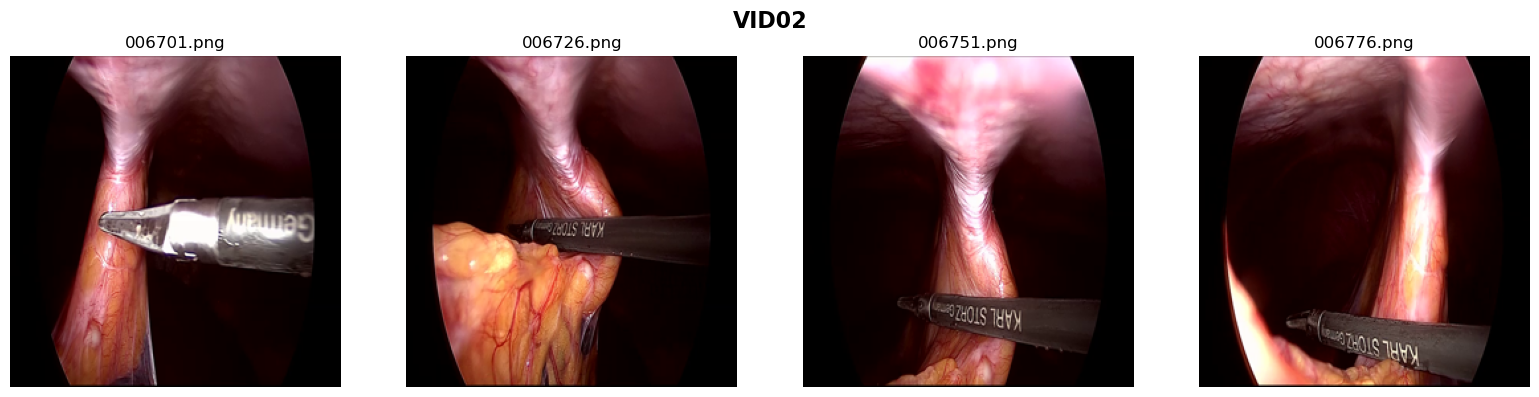

4 Frames per VID04


4 Frames per VID103


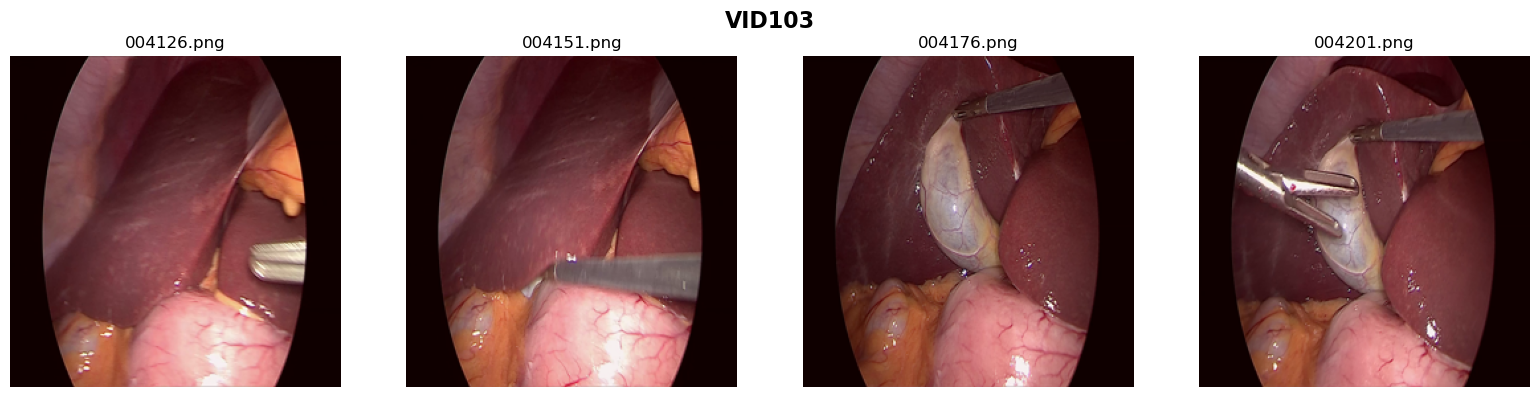

4 Frames per VID11


4 Frames per VID13


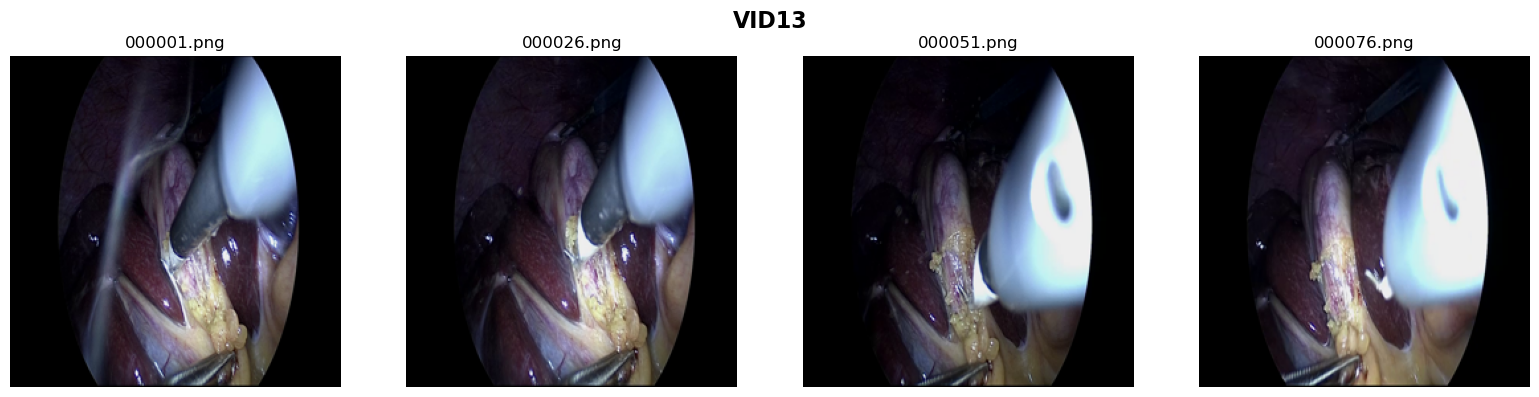

4 Frames per VID17


4 Frames per VID23


4 Frames per VID31


4 Frames per VID37


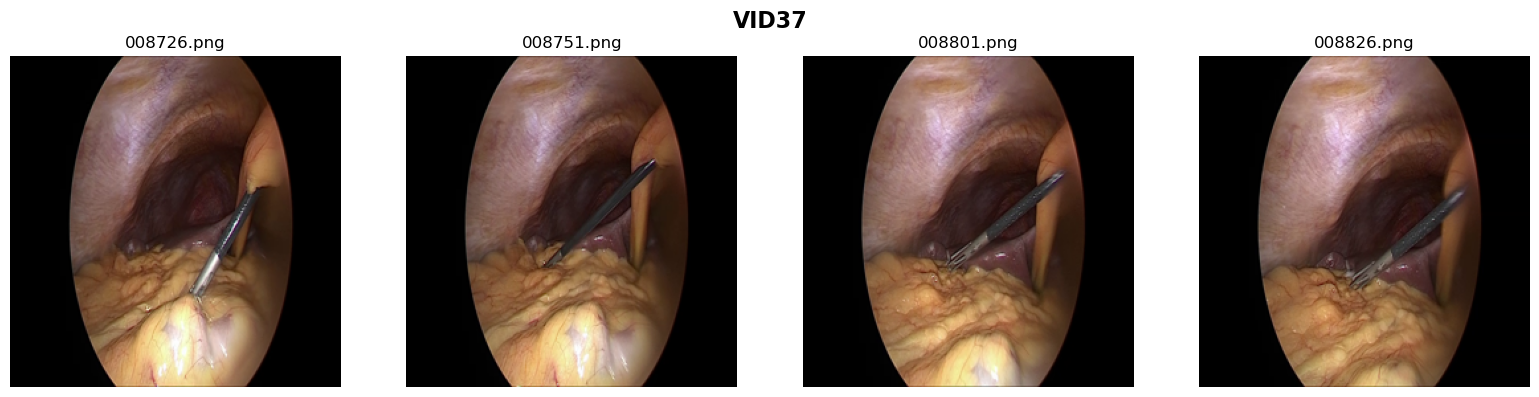

4 Frames per VID96


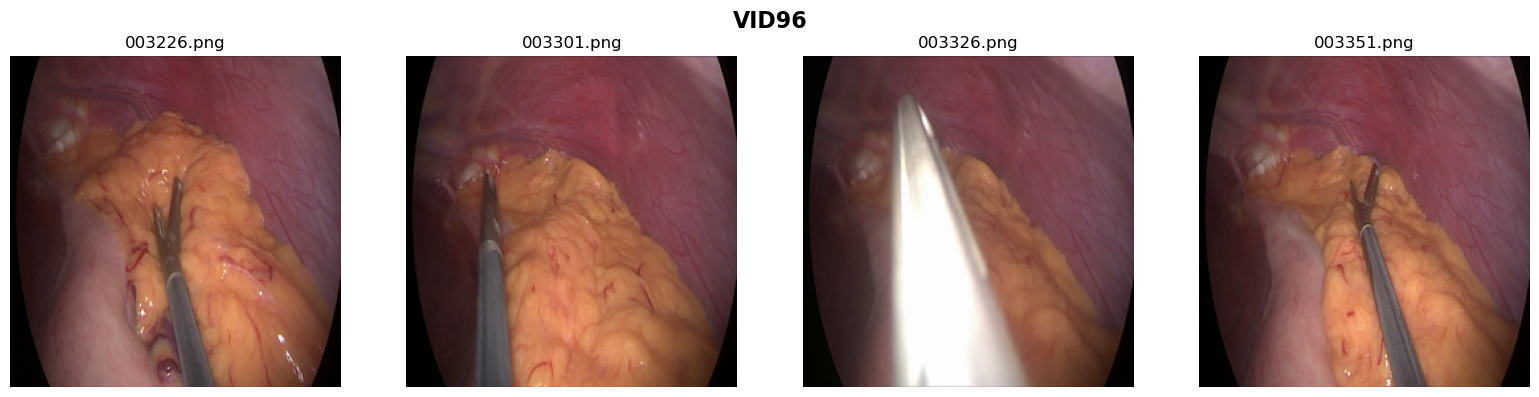

In [7]:
video_ids = [
    "VID02", "VID04", "VID103", "VID11", "VID13",
    "VID17", "VID23", "VID31", "VID37", "VID96"
]

for vid in video_ids:
    print(f"4 Frames per {vid}")
    prefix = f"Training/{vid}/Frames/"
    load_frames(prefix)


## Exploratory Data Analysis (EDA)

We check distribution of annotations, category frequency, sample frames, and dataset consistency to better understand labeling patterns.


In [8]:
df = pd.read_json("s3://surgimind01/Training/VID02/vid02.json")

In [9]:
df.shape

(2562, 4)

In [10]:
df.head(10)

info annotations  \
dataset                                           CholecTrack20         NaN   
description   Laparoscopic cholecystectomy video dataset for...         NaN   
year                                                       2022         NaN   
version                                                     1.0         NaN   
author                                         Chinedu I. Nwoye         NaN   
copyright        CAMMA, ICube, University of Strasbourg, France         NaN   
url                                  http://camma.u-strasbg.fr/         NaN   
date_created                                         2019-01-01         NaN   
bbox format   tlwh = [top_left_x, top_left_y, box_width, box...         NaN   
license       Creative Commons license CC BY-NC-SA 4.0 LICEN...         NaN   

             categories video  
dataset             NaN   NaN  
description         NaN   NaN  
year                NaN   NaN  
version             NaN   NaN  
author              NaN   NaN  
copyright           NaN   NaN  
url                 NaN   NaN  
date_created        NaN   NaN  
bbox format         NaN   NaN  
license             NaN   NaN

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2562 entries, dataset to width
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   info         10 non-null     object
 1   annotations  2545 non-null   object
 2   categories   2 non-null      object
 3   video        5 non-null      object
dtypes: object(4)
memory usage: 100.1+ KB


In [12]:
df['annotations']

dataset        NaN
description    NaN
year           NaN
version        NaN
author         NaN
              ... 
name           NaN
num_frames     NaN
split          NaN
height         NaN
width          NaN
Name: annotations, Length: 2562, dtype: object

## Cleaning and Normalizing Annotation Data

Some annotation files contain nested structures. We convert them into a usable tabular format for analysis and training.


In [13]:
"""
Step-by-step process to flatten the nested 'annotations' column.

1. Filter out rows where 'annotations' is empty or NaN.
2. Explode the column so each list item becomes a separate row.
3. Normalize each dictionary in the exploded column into individual columns.
4. Preview the structured flattened data.
"""
rows = []
pd.set_option("display.max_columns", None)
annotations = df["annotations"]

for id, ann_list in annotations.items():
    if not isinstance(ann_list, list):
        continue  # skip NaN / invalid entries

    for ann in ann_list:
        row = ann.copy()
        row["id"] = int(id)
        rows.append(row)

df_ann_flat = pd.DataFrame(rows)
df_ann_flat.head()



instrument  verb  target  phase  triplet  \
0           3    -1      -1      0       -1   
1           3    -1      -1      0       -1   
2           3    -1      -1      0       -1   
3           3    -1      -1      0       -1   
4           3    -1      -1      0       -1   

                                           tool_bbox  operator  iscrowd  \
0  [0.268149882903981, 0.42916666666666603, 0.364...         3        0   
1  [0.300936768149882, 0.49166666666666603, 0.093...         3        0   
2  [0.28337236533957805, 0.716666666666666, 0.114...         3        0   
3  [0.26346604215456604, 0.7645833333333331, 0.11...         3        0   
4  [0.5807962529274, 0.47500000000000003, 0.15339...         3        0   

       area  score  intraoperative_track  intracorporeal_track  \
0   47174.0    1.0                     1                     1   
1   60652.0    1.0                     1                     1   
2   83248.0    1.0                     1                     1   
3   82575.0    1.0                     1                     1   
4  113088.0    1.0                     1                     1   

   visibility_track  visibility  crowded  visible  occluded  bleeding  smoke  \
0                 1           1        0        1         0         0      0   
1                 1           1        0        1         0         0      0   
2                 1           1        0        1         0         0      0   
3                 1           1        0        1         0         0      0   
4                 1           1        0        1         0         0      0   

   blurred  undercoverage  reflection  stainedlens    id  
0        0              0           0            0  6701  
1        0              0           0            0  6726  
2        0              0           0            0  6751  
3        0              0           0            0  6776  
4        0              1           0            0  6801

In [14]:
df_ann_flat[df_ann_flat['id'].duplicated(keep=False)] \
    .sort_values('id')


instrument  verb  target  phase  triplet  \
41             3    -1      -1      0       -1   
42             0    -1      -1      0       -1   
43             0    -1      -1      0       -1   
44             3    -1      -1      0       -1   
47             0    -1      -1      0       -1   
...          ...   ...     ...    ...      ...   
4115           3    -1      -1      6       -1   
4117           6    -1      -1      6       -1   
4116           1    -1      -1      6       -1   
4119           6    -1      -1      6       -1   
4118           1    -1      -1      6       -1   

                                              tool_bbox  operator  iscrowd  \
41    [0.8067915690866511, 0.770833333333333, 0.0503...         3        0   
42    [0.16276346604215403, 0.5437500000000001, 0.46...         1        0   
43    [0.166276346604215, 0.522916666666666, 0.42388...         1        0   
44    [0.34074941451990604, 0.44375000000000003, 0.1...         3        0   
47    [0.24473067915690802, 0.21250000000000002, 0.4...         1        0   
...                                                 ...       ...      ...   
4115  [0.391100702576112, 0.12291666666666601, 0.286...         1        0   
4117  [0.372365339578454, 0.6395833333333331, 0.3758...         0        0   
4116  [0.368852459016393, 0.089583333333333, 0.17915...         1        0   
4119  [0.299765807962529, 0.5625, 0.535128805620608,...         0        0   
4118  [0.295081967213114, 0.0375, 0.203747072599531,...         1        0   

          area  score  intraoperative_track  intracorporeal_track  \
41    254930.0    1.0                     1                     1   
42     36279.0    1.0                     2                     2   
43     35642.0    1.0                     2                     2   
44     61983.0    1.0                     1                     1   
47     21318.0    1.0                     2                     2   
...        ...    ...                   ...                   ...   
4115   19706.0    1.0                     1                    39   
4117   97626.0    1.0                     9                    19   
4116   13545.0    1.0                     8                    40   
4119   69120.0    1.0                     9                    19   
4118    4536.0    1.0                     8                    40   

      visibility_track  visibility  crowded  visible  occluded  bleeding  \
41                   1           1        0        1         1         0   
42                   2           1        0        1         1         0   
43                   2           1        0        1         1         0   
44                   1           1        0        1         1         0   
47                   2           1        0        1         1         0   
...                ...         ...      ...      ...       ...       ...   
4115               155           1        0        1         1         0   
4117               150           1        0        1         1         0   
4116               156           1        0        1         1         0   
4119               150           1        0        1         1         0   
4118               156           1        0        1         1         0   

      smoke  blurred  undercoverage  reflection  stainedlens     id  
41        0        0              1           0            0   8051  
42        0        0              1           0            0   8051  
43        0        0              1           0            0   8076  
44        0        0              1           0            0   8076  
47        0        0              1           0            0   8151  
...     ...      ...            ...         ...          ...    ...  
4115      0        0              0           0            1  75426  
4117      0        0              0           0            1  75451  
4116      0        0              0           0            1  75451  
4119      0        0      

In [15]:
df_ann_flat['id'].value_counts()[lambda x: x > 1]

id
70226    4
70401    4
70376    4
70501    4
70251    4
        ..
73926    2
73951    2
73976    2
74001    2
74026    2
Name: count, Length: 1331, dtype: int64

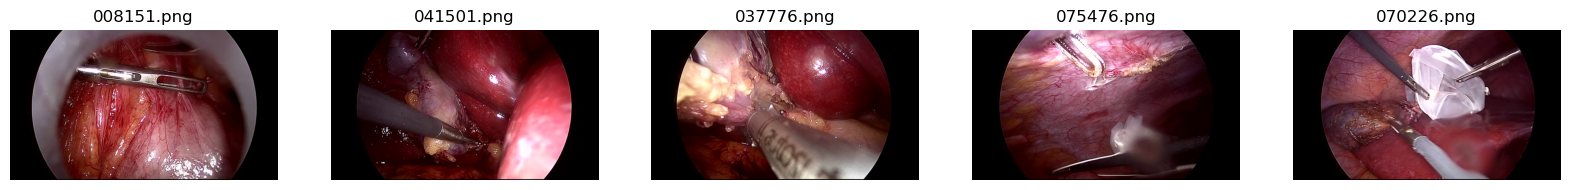

In [24]:
# this show there are multiple annotations provided for one frame lets inspect that 
image_keys = [
    "Training/VID02/Frames/008151.png",
    "Training/VID02/Frames/041501.png",
    "Training/VID02/Frames/037776.png",
    "Training/VID02/Frames/075476.png",
    "Training/VID02/Frames/070226.png"
]


def show_s3_images(bucket, keys):
    plt.figure(figsize=(20, 10))

    for i, key in enumerate(keys):
        try:
           obj = s3.get_object(Bucket=bucket, Key=key)
            img = Image.open(io.BytesIO(obj["Body"].read()))

            plt.subplot(1, len(keys), i + 1)
            plt.imshow(img)
            plt.title(key.split("/")[-1])
            plt.axis("off")

        except s3.exceptions.NoSuchKey:
            print(f"❌ Key not found: {key}")

    plt.show()

show_s3_images(bucket, image_keys)

In [17]:
for i in range(0,8):
    print(f"Phase number {i}: {(df_ann_flat['phase'] == i).sum()}")
"""
Phase Mapping (Derived from CholecTrack 80 and CholecT50
0 -> Preparartion
1 -> Calot Triangel dissection
2 -> Clipping and cutting
3 -> Gallbladder dissection
4 -> Gallbladder packaging
5 -> Cleaning and coagulation
6 -> Gallbladder retraction
7 -> Final inspection/ closure
"""
    

Phase number 0: 465
Phase number 1: 1368
Phase number 2: 384
Phase number 3: 1440
Phase number 4: 115
Phase number 5: 320
Phase number 6: 36
Phase number 7: 0


'\nPhase Mapping (Derived from CholecTrack 80 and CholecT50\n0 -> Preparartion\n1 -> Calot Triangel dissection\n2 -> Clipping and cutting\n3 -> Gallbladder dissection\n4 -> Gallbladder packaging\n5 -> Cleaning and coagulation\n6 -> Gallbladder retraction\n7 -> Final inspection/ closure\n\nPhasesku annotate karte waqt lets do 200 FPS  \n'

In [18]:
df_ann_flat['id'].value_counts()

id
70226    4
70401    4
70376    4
70501    4
70251    4
        ..
74901    1
75026    1
75076    1
75126    1
6801     1
Name: count, Length: 2545, dtype: int64

In [19]:
df_ann_flat.shape

(4128, 24)

In [20]:
df_ann_flat.tail()

instrument  verb  target  phase  triplet  \
4123           0    -1      -1      6       -1   
4124           6    -1      -1      6       -1   
4125           6    -1      -1      6       -1   
4126           0    -1      -1      6       -1   
4127           0    -1      -1      6       -1   

                                              tool_bbox  operator  iscrowd  \
4123  [0.18032786885245902, 0.45833333333333304, 0.2...         2        0   
4124  [0.12412177985948401, 0.6666666666666661, 0.14...         0        0   
4125  [0.12412177985948401, 0.622916666666666, 0.288...         0        0   
4126  [0.38992974238875805, 0.39375000000000004, 0.1...         2        0   
4127  [0.34074941451990604, 0.385416666666666, 0.258...         2        0   

         area  score  intraoperative_track  intracorporeal_track  \
4123  33880.0    1.0                     4                     4   
4124  33920.0    1.0                     9                    19   
4125  31694.0    1.0                     9                    19   
4126  62937.0    1.0                     4                     4   
4127  53835.0    1.0                     4                     4   

      visibility_track  visibility  crowded  visible  occluded  bleeding  \
4123               157           1        0        1         0         0   
4124               158           1        0        1         0         0   
4125               158           1        0        1         0         0   
4126               157           1        0        1         0         0   
4127               157           1        0        1         0         0   

      smoke  blurred  undercoverage  reflection  stainedlens     id  
4123      0        0              1           0            1  75951  
4124      0        0              0           0            1  76276  
4125      0        0              0           0            1  76301  
4126      0        0              1           0            1  76351  
4127      0        0              1           0            1  76376

In [21]:

from collections import defaultdict

bucket = "surgimind01"
prefix = "Training/"

s3 = boto3.client("s3")

valid_suffixes = (".png", ".jpg", ".jpeg")
video_pattern = re.compile(r"Training/(VID\d+)/Frames/")

token = None
video_counts = defaultdict(int)

while True:
    params = {
        "Bucket": bucket,
        "Prefix": prefix,
        "MaxKeys": 1000
    }
    if token:
        params["ContinuationToken"] = token

    response = s3.list_objects_v2(**params)

    for obj in response.get("Contents", []):
        key = obj["Key"]

        if not key.lower().endswith(valid_suffixes):
            continue

        match = video_pattern.search(key)
        if match:
            video_id = match.group(1)
            video_counts[video_id] += 1

    if response.get("IsTruncated"):
        token = response["NextContinuationToken"]
    else:
        break

for video, count in sorted(video_counts.items()):
    print(f"{video} -> {count} images")



VID02 -> 2545 images
VID04 -> 1189 images
VID103 -> 1667 images
VID11 -> 2962 images
VID13 -> 924 images
VID17 -> 1066 images
VID23 -> 1570 images
VID31 -> 3903 images
VID37 -> 1201 images
VID96 -> 1221 images


In [22]:
from pandas import json_normalize
df_categories = df[df["categories"].notna()].copy()
df_categories = df_categories.explode("categories")
df_categories_flat = json_normalize(df_categories["categories"])
df_categories_flat


id                                 name supercategory multi-instance
0    0                              grasper       grasper           True
1    1                              bipolar       grasper          False
2    2                                 hook          hook          False
3    3                             scissors      scissors          False
4    4                              clipper       clipper          False
5    5                            irrigator     irrigator          False
6    6                         specimen-bag  specimen-bag          False
7    0                                 null           NaN            NaN
8    1        main-surgeon-left-hand (MSLH)           NaN            NaN
9    2  assistant-surgeon-right-hand (ASRH)           NaN            NaN
10   3       main-surgeon-right-hand (MSRH)           NaN            NaN

In [23]:
df_video = df[df["video"].notna()].copy()
df_video = df_video.explode("video")
df_video_flat = json_normalize(df_video["video"])
df_video_flat


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

### Model Training and Data Prepartion Involving annotating 

* Model Traning for the *tool detection*

In [26]:
tools = {
    0 :"grasper",	
	1 :	"bipolar",	
	2 :	"hook",
	3 :	"scissors",
	4 :	"clipper",
	5 :	"irrigator",	
	6 :	"specimen-bag"
}

In [29]:
operators = {
    1 :	"main-surgeon-left-hand (MSLH)",
	2 :	"assistant-surgeon-right-hand (ASRH)",
	3 :	"main-surgeon-right-hand (MSRH)"
}

In [31]:
phase = {
    0 : "Preparartion",
    1 : "Calot Triangel dissection",
    2 : "Clipping and cutting",
    3 : "Gallbladder dissection",
    4 : "Gallbladder packaging",
    5 : "Cleaning and coagulation",
    6 : "Gallbladder retraction",
    7 : "Final inspection/ closure"
}

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2057484130.py, line 2)

In [30]:
# Coverting the annotatiosn dictionary -> YOlO labels
import cv2

def covert_bbox_to_yolo(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    xc = (x1+x2)/ 2.0 / img_w
    yc = (y1+y2)/ 2.0 /img_h
    w = (x2-x1)/ img_w
    h = (y2-y1) /img_h
    return xc, yc, w, h

In [32]:
def write_yolo_labels(tool_annotations, frames_dir, labels_dir):
    os.makedirs(labels_dir, exist_ok=True)

    for frame_id, tools in tool_annotations["frames"].items():
        img_path = f"{frames_dir}/frame_{frame_id:05d}.jpg"
        label_path = f"{labels_dir}/frame_{frame_id:05d}.txt"

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        with open(label_path, "w") as f:
            for t in tools:
                cls_id = TOOL_NAME_TO_ID[t["tool"]]
                xc, yc, bw, bh = convert_bbox_to_yolo(
                    t["bbox"], w, h
                )
                f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")
